# Alternative Fitting Procedure with Surrogate Loss Function

This example demonstrates an alternative way to fit a boosted model using a for loop such that holdout loss functions amongst other things can be customized.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from genestboost import BoostedLinearModel
from genestboost.weak_learners import SimplePLS
from genestboost.link_functions import LogitLink
from genestboost.loss_functions import LogLoss

%matplotlib inline

### Create a Dummy Classification Dataset

In [2]:
X, y = make_classification(n_samples=20000,
                           n_features=50,
                           n_informative=20,
                           weights=(0.85, 0.15),
                           random_state=11,
                           shuffle=False)
X = scale(X)

### Alternative Fitting Procedure

In [3]:
X_train, X_val, y_train, y_val = (
    train_test_split(X, y, test_size=0.30, stratify=y, random_state=13)
)

# notice no validation set arguments in the init - we will compute holdout in our loop below
model = BoostedLinearModel(
    link=LogitLink(),
    loss=LogLoss(),
    model_callback=SimplePLS,   # for now, still need to specify this arg
    model_callback_kwargs={},
    alpha=5.0,
    step_type="decaying",
    weights="newton",)

# HELPER
def calc_roc(yp, yp_val):
    """Closure of y_train and y_val."""
    return (roc_auc_score(y_train, yp), roc_auc_score(y_val, yp_val))

# instead of using fit, we will use a for-loop to fit the model while using
# ROC-AUC on the holdout set to determine stoppage
yp, eta_p = model.initialize_model(X_train, y_train)   ### IMPORTANT - initializes the model
eta_p_val = model.decision_function(X_val)
yp_val = model.compute_link(eta_p_val, inverse=True)
loss_list = [calc_roc(yp, yp_val)]   # rocauc loss [(train, val)]

# main loop
max_iterations, min_iterations, iter_stop = 2000, 20, 20
for i in range(max_iterations):
    yp, eta_p = model.boost(X_train, y_train, yp, eta_p, SimplePLS, {})
    eta_p_val += model.decision_function_single(X_val)   # predict on only the last model for performance
    yp_val = model.compute_link(eta_p_val, inverse=True)
    loss_list.append(calc_roc(yp, yp_val))
    
    if i >= min_iterations and i > iter_stop:
        loss_check = loss_list[-iter_stop][1]
        if loss_list[-1][1] < loss_check:
            break
            
print("Number of Boosting Iterations: {:d}".format(model.get_iterations()))

Number of Boosting Iterations: 151


### Plot the loss history

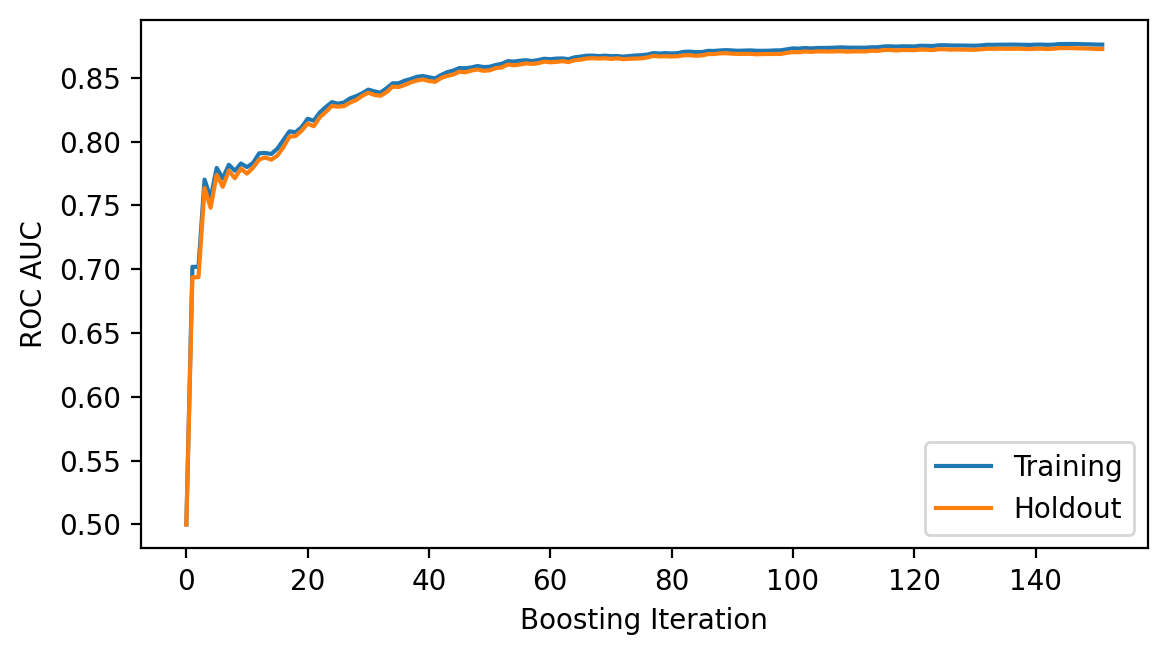

In [4]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(np.array(loss_list), label=["Training", "Holdout"])
ax.legend(loc="best")
ax.set_ylabel("ROC AUC")
ax.set_xlabel("Boosting Iteration");

### Plot Coefficient History

The coefficients are scaled by the standard deviation of the corresponding features in the data set to get standardized coefficients.

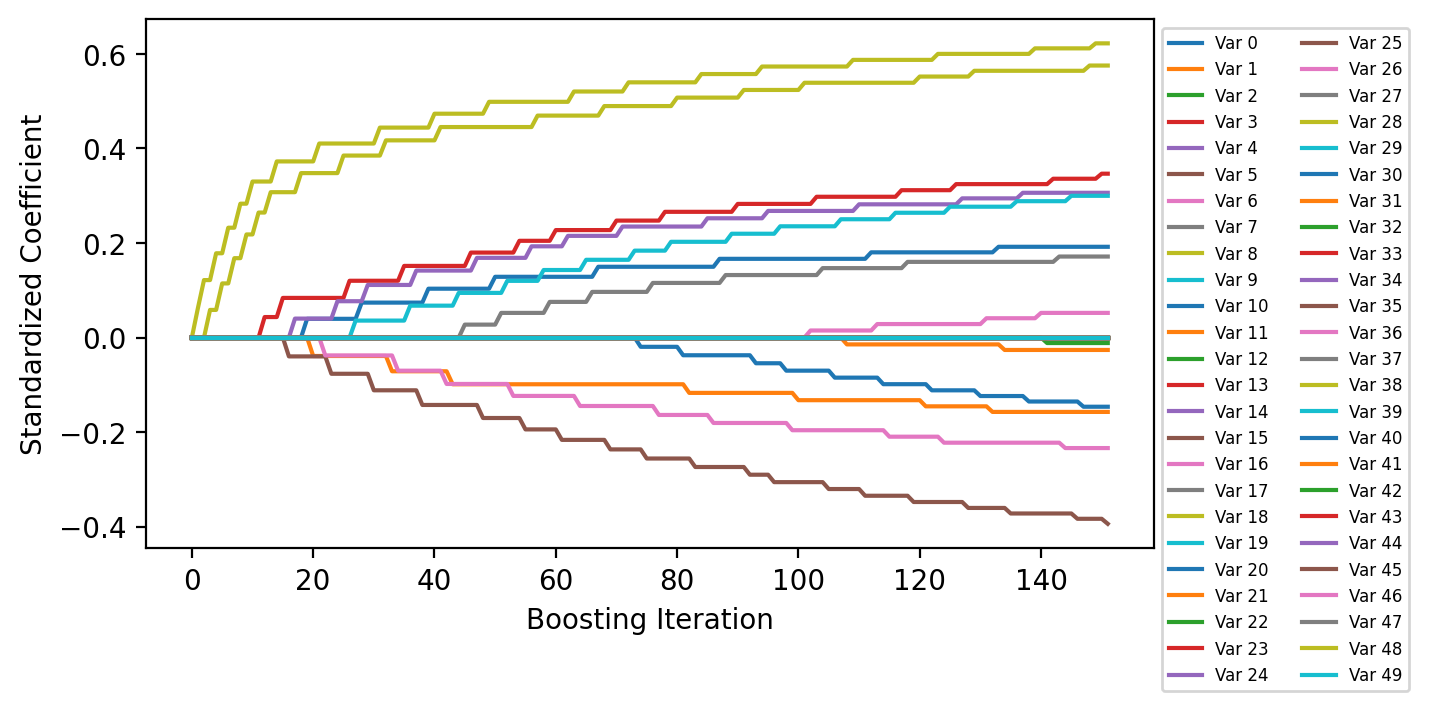

In [5]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(model.get_coefficient_history(scale=X.std(ddof=1, axis=0)), label=[f"Var {i:d}" for i in range(X.shape[1])])
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2, fontsize=6)
ax.set_xlabel("Boosting Iteration")
ax.set_ylabel("Standardized Coefficient");

### Order that Variables Entered the Model

In [6]:
print("Number of Selected Variables in the Model: {:d}".format(len(model.get_coefficient_order())))
model.get_coefficient_order()

Number of Selected Variables in the Model: 14


[8, 18, 3, 5, 14, 0, 1, 6, 19, 17, 10, 16, 11, 2]